In [1]:
%cd /kaggle/working

/kaggle/working


In [2]:
import pandas as pd
import yaml
import sys
import os
from glob import glob
import gc
from pathlib import Path
import pickle
from tqdm import tqdm
import numpy as np

import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.cuda.amp as amp
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.optim.lr_scheduler import ReduceLROnPlateau

import pytorch_lightning as pl
from torchmetrics import MetricCollection, MeanSquaredError
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping


sys.path.append('/kaggle/src')
from utils.metric import compute_comptetition_metric
from utils.postprocess import post_process
from utils.set_seed import seed_base_torch
from utils.feature_contena import Features
from utils.lightning_utils import MyLightningDataModule

PACKAGE_DIR = Path("/kaggle/src")
CFG = yaml.safe_load(open(PACKAGE_DIR / "config.yaml", "r"))
print(CFG["gru"]["execution"]["exp_id"])

CFG["output_dir"] = f"/kaggle/output/{CFG['gru']['execution']['exp_id']}"
!rm -r {CFG["output_dir"]}
os.makedirs(CFG["output_dir"], exist_ok=True)

seed_base_torch(CFG["env"]["seed"])

2023-10-14 00:52:11.797378: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/opt/conda/lib
2023-10-14 00:52:11.797661: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/opt/conda/lib
2023-10-14 00:52:11.797669: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlo

exp_081


In [3]:
ANGLEZ_MEAN = -8.810
ANGLEZ_STD = 35.52
ENMO_MEAN = 0.04132
ENMO_STD = 0.1018

SEQ_LEN = 5000

In [4]:
class ZzzDataset(Dataset):
    def __init__(self, dfs: list[pd.DataFrame], mode: str, features: Features):
        self.dfs = dfs
        self.mode = mode
        self.features = features

    def __len__(self):
        return len(self.dfs)

    def __getitem__(self, index):
        df = self.dfs[index]

        feats = df[self.features.all_features()].values.astype(np.float32)

        if self.mode == "train":
            targets = df[["wakeup_target", "onset_target"]].values.astype(np.float32)
            return feats, targets
        else:
            return feats

In [5]:
class ZzzGRUModule(pl.LightningModule):
    def __init__(
            self, 
            dropout=0.2,
            input_numerical_size=2,
            numeraical_linear_size = 64,
            model_size = 128,
            linear_out = 128,
            out_size=2,
            loss_fn=nn.CrossEntropyLoss(), 
            lr=0.001, 
            weight_decay=0
        ):
        super().__init__()
        
        self.numerical_linear  = nn.Sequential(
                nn.Linear(input_numerical_size, numeraical_linear_size),
                nn.LayerNorm(numeraical_linear_size)
            )
        
        self.rnn = nn.GRU(numeraical_linear_size, model_size,
                            num_layers = 2, 
                            batch_first=True,
                            bidirectional=True)
        self.linear_out  = nn.Sequential(
            nn.Linear(model_size*2, linear_out),
            nn.LayerNorm(linear_out),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(linear_out, out_size))
        self._reinitialize()

        self.loss_fn = loss_fn
        self.lr = lr
        self.weight_decay = weight_decay

        self.train_metrics = MetricCollection([], prefix="")
        self.valid_metrics = MetricCollection([], prefix="val_")
        
        self.val_step_outputs = []
        self.val_step_labels = []


    def _reinitialize(self):
        """
        Tensorflow/Keras-like initialization
        """
        for name, p in self.named_parameters():
            if 'rnn' in name:
                if 'weight_ih' in name:
                    nn.init.xavier_uniform_(p.data)
                elif 'weight_hh' in name:
                    nn.init.orthogonal_(p.data)
                elif 'bias_ih' in name:
                    p.data.fill_(0)
                    # Set forget-gate bias to 1
                    n = p.size(0)
                    p.data[(n // 4):(n // 2)].fill_(1)
                elif 'bias_hh' in name:
                    p.data.fill_(0)

    def forward(self, feat):
        numerical_embedding = self.numerical_linear(feat)
        output,_ = self.rnn(numerical_embedding)
        output = self.linear_out(output)
        return output

    def training_step(self, batch, batch_idx):
        X, y = batch
        preds = self.forward(X)

        loss = self.loss_fn(preds, y)

        self.train_metrics(preds, y)
        self.log("loss", loss, prog_bar=True, logger=True, on_epoch=True, on_step=True,)
        self.log_dict(self.train_metrics, prog_bar=True, logger=True, on_epoch=True, on_step=True,)
        return {"loss": loss}

    def validation_step(self, batch, batch_idx):
        X, y = batch
        preds = self.forward(X)
        
        self.val_step_outputs.append(preds)
        self.val_step_labels.append(y)

    def on_validation_epoch_end(self):
        preds = torch.cat(self.val_step_outputs)
        labels = torch.cat(self.val_step_labels)
        self.val_step_outputs.clear()
        self.val_step_labels.clear()
        loss = self.loss_fn(preds, labels)

        self.valid_metrics(preds, labels)
        self.log("val_loss", loss, prog_bar=False, logger=True, on_epoch=True, on_step=False,)
        self.log_dict(self.valid_metrics, prog_bar=False, logger=True, on_epoch=True, on_step=False,)

        # ログをprint
        self.print_metric(preds, labels, "valid")

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        scheduler = ReduceLROnPlateau(optimizer, factor=0.1, patience=3, verbose=True)
        return {"optimizer": optimizer, 
                "lr_scheduler": scheduler, 
                "monitor": "val_loss"}
                
    def print_metric(self, y_hat, y, train_or_valid="train"):
        """
        ログをprintする。次のepochが終わると上書きされてしまうので。
        TODO: たぶんもっとマシな方法があるので探す。
        """
        if train_or_valid == "train":
            metrics = self.train_metrics
        else:
            metrics = self.valid_metrics
        loss = self.loss_fn(y_hat, y)

        print(f"[epoch {self.trainer.current_epoch}] {train_or_valid}: ", end="")
        print(f"{type(self.loss_fn).__name__}={loss:.4f}", end=", ")
        for name in metrics:
            v = metrics[name](y_hat, y)
            print(f"{name}={v:.4f}", end=", ")
        print()

In [6]:
files = glob(f"{CFG['dataset']['step_csv_dir']}/*.csv")
dfs = []
for file in tqdm(files):
    df = pd.read_csv(file)
    dfs.append(df)
train = pd.concat(dfs, axis=0).reset_index(drop=True)
del dfs
gc.collect()

100%|██████████| 277/277 [01:18<00:00,  3.54it/s]


3045

In [7]:
# 標準化
train["anglez"] = (train["anglez"] - ANGLEZ_MEAN) / ANGLEZ_STD
train["enmo"] = (train["enmo"] - ENMO_MEAN) / ENMO_STD

In [8]:
# cv splitとマージ
cv_split = pd.read_csv(CFG['dataset']['cv_split_path'])
train["fold"] = train["series_id"].map(cv_split.set_index("series_id")["fold"])
display(train.head(5))
train.shape

,series_id,step,timestamp,anglez,enmo,event,target,onset_target,wakeup_target,fold
0,af91d9a50547,0,2018-02-05T11:15:00-0500,2.747306,-0.405894,NaN,1,0.0,0.0,3
1,af91d9a50547,1,2018-02-05T11:15:05-0500,2.747331,-0.405894,NaN,1,0.0,0.0,3
2,af91d9a50547,2,2018-02-05T11:15:10-0500,2.747416,-0.405894,NaN,1,0.0,0.0,3
3,af91d9a50547,3,2018-02-05T11:15:15-0500,2.747314,-0.405894,NaN,1,0.0,0.0,3
4,af91d9a50547,4,2018-02-05T11:15:20-0500,2.747441,-0.405894,NaN,1,0.0,0.0,3


(127946340, 10)

In [9]:
# SEQ_LEN ごとに分割
dfs = []
for series_id, df in tqdm(train.groupby("series_id")):
    df = df.sort_values("step")

    for start in range(0, len(df), SEQ_LEN // 2):
        end = start + SEQ_LEN
        if end > len(df):
            end = len(df)
            start = end - SEQ_LEN
            assert start >= 0
        dfs.append(df.iloc[start: end])
gc.collect()

features = Features()
features.add_num_features(["anglez", "enmo"])
dataset_oof = ZzzDataset(dfs, 'train', features)
feats, targets = dataset_oof[0]
feats.shape, targets.shape

100%|██████████| 277/277 [00:20<00:00, 13.58it/s]


((5000, 2), (5000, 2))

In [10]:
!rm -r logs

rm: cannot remove 'logs': No such file or directory


In [11]:
fold_oof_dfs = []
for fold in range(5):
    print(f"== fold {fold} ==")
    
    # 学習・評価データ
    train_dfs = [df for df in dfs if df["fold"].unique()[0] != fold]
    valid_dfs = [df for df in dfs if df["fold"].unique()[0] == fold]
    train_dataset = ZzzDataset(train_dfs, mode="train", features=features)
    valid_dataset = ZzzDataset(valid_dfs, mode="train", features=features)
    data_module = MyLightningDataModule(train_dataset, valid_dataset, batch_size=64)

    # モデル
    model = ZzzGRUModule(lr=0.001, loss_fn=nn.MSELoss())
    
    # コールバック
    cp_callback = ModelCheckpoint(
        "logs/", 
        filename=f"best_model_fold{fold}",
        monitor="val_loss",
        mode="min",
        save_top_k=1,
        save_last=False,
    )
    es_callback = EarlyStopping(
        monitor="val_loss",
        mode="min",
        patience=5,
    )

    # 学習
    trainer = pl.Trainer(
        callbacks=[cp_callback, es_callback],
        )
    trainer.fit(model, datamodule=data_module)

    # 推論
    model = ZzzGRUModule.load_from_checkpoint(
        f"logs/best_model_fold{fold}.ckpt", loss_fn=nn.BCEWithLogitsLoss()).to("cuda")
    model.eval()
    preds = []
    with torch.no_grad():
        for X, y in data_module.val_dataloader():
            pred = model(X.to("cuda")).detach().cpu().numpy()
            preds.append(pred)

    oof_dfs = []
    for pred, df in zip(np.vstack(preds), valid_dfs):
        df[["wakeup_oof", "onset_oof"]] = pred
        oof_dfs.append(df)

    oof_df = pd.concat(oof_dfs)
    oof_df = oof_df.groupby(["series_id", "step"]).mean().reset_index().sort_values(["series_id", "step"])
    fold_oof_dfs.append(oof_df)
    break
train = pd.concat(fold_oof_dfs)

== fold 0 ==


Sanity Checking: 0it [00:00, ?it/s]

[epoch 0] valid: MSELoss=0.6836, 


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[epoch 0] valid: MSELoss=0.2969, 


Validation: 0it [00:00, ?it/s]

[epoch 1] valid: MSELoss=0.2208, 


Validation: 0it [00:00, ?it/s]

[epoch 2] valid: MSELoss=0.2088, 


Validation: 0it [00:00, ?it/s]

[epoch 3] valid: MSELoss=0.2092, 


Validation: 0it [00:00, ?it/s]

[epoch 4] valid: MSELoss=0.1985, 


Validation: 0it [00:00, ?it/s]

[epoch 5] valid: MSELoss=0.2013, 


Validation: 0it [00:00, ?it/s]

[epoch 6] valid: MSELoss=0.2029, 


Validation: 0it [00:00, ?it/s]

[epoch 7] valid: MSELoss=0.2044, 


Validation: 0it [00:00, ?it/s]

[epoch 8] valid: MSELoss=0.2110, 
Epoch 00009: reducing learning rate of group 0 to 1.0000e-04.


Validation: 0it [00:00, ?it/s]

[epoch 9] valid: MSELoss=0.1985, 


In [12]:
dfs = []
df = train[["series_id", "step", "wakeup_oof"]].copy()
df["event"] = "wakeup"
df["score"] = df["wakeup_oof"]
dfs.append(df[['series_id', 'step', 'event', 'score']])

df = train[["series_id", "step", "onset_oof"]].copy()
df["event"] = "onset"
df["score"] = df["onset_oof"]
dfs.append(df[['series_id', 'step', 'event', 'score']])

train = pd.concat(dfs)

In [ ]:
len(train)

51355080

In [ ]:
(train["score"]>0.1).mean()

0.07362874325188472

In [ ]:
train = train[train["score"]>0.1].reset_index(drop=True)

<AxesSubplot: >

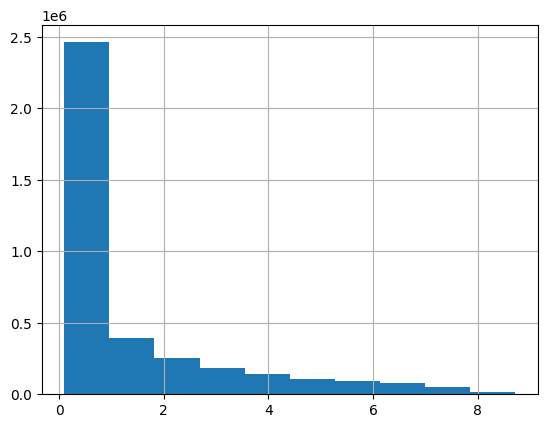

In [ ]:
train["score"].hist()

## Dynamic-Range NMS

In [ ]:
from scipy.interpolate import interp1d
from multiprocessing import Pool
from tqdm import tqdm
import numpy as np

score2range = interp1d([-100, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 100], [0, 0, 12, 36, 60, 90, 120, 150, 180, 240, 300, 360, 360])
range2score = interp1d([0, 12, 36, 60, 90, 120, 150, 180, 240, 300, 360], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
score2range(1.5)

def process_group(df):
    dfs = []
    df = df.sort_values("score", ascending=False).reset_index(drop=True)
    used = np.zeros(len(df))
    reduce_rate = np.ones(df["step"].max() + 500)
    for _ in range(min(len(df), 300)):
        best_score = -1e10
        best_idx = -1
        best_step = -1
        best_row = -1
        for i, row in df.iterrows():
            if used[i]:
                continue
            score = row["score"] / reduce_rate[row["step"]]
            if score > best_score:
                best_score = score
                best_idx = i
                best_step = row["step"]
                row["reduced_score"] = score
                best_row = row
        dfs.append(best_row)
        used[best_idx] = True

        range_ = score2range(best_score)
        for r in range(1, int(range_)):
            reduce = range2score(range_ - r) + 1
            reduce_rate[best_step + r] = max(reduce_rate[best_step + r], reduce)
            if best_step - r >= 0:
                reduce_rate[best_step - r] = max(reduce_rate[best_step - r], reduce)
    return dfs

groups = [group for _, group in train.groupby("series_id")]
with Pool(30) as p:  
    results = list(tqdm(p.imap(process_group, groups), total=len(groups)))
all_results = [item for sublist in results for item in sublist]
sub = pd.DataFrame(all_results)
sub["score"] = sub["reduced_score"]

  0%|          | 0/55 [09:48<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
# スコア計算
labels = pd.read_csv(f"{CFG['dataset']['competition_dir']}/train_events.csv").dropna()
labels = labels[labels["series_id"].isin(sub["series_id"].unique())]
score, ap_table = compute_comptetition_metric(labels, sub)

print(f"score: {score:.4f}")
display(ap_table)
sub.to_csv(os.path.join(CFG["output_dir"], "submission_after_nms.csv"), index=False)